In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import statsmodels.api as sm
# from sklearn.linear_model import QuantileRegressor, LinearRegression
# from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_pinball_loss

# = = = = = =
# own stuff
# = = = = = =
os.chdir("C:/2023_11-PTSFC")
import data_prepro as data_prepro
import model_train as model_train
import model_fcast as model_fcast
# from data_prepro import get_energy_data_today, create_dummy_df, create_features_df

In [2]:
from importlib import reload
reload(data_prepro)
reload(model_train)
reload(model_fcast)

<module 'model_fcast' from 'C:\\2023_11-PTSFC\\model_fcast.py'>

### Params

In [4]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fcast_hor = [36, 40, 44, 60, 64, 68] # in hours

# = = = = = = = = = = = = = 
# generate prediction timestamps based on t0 = following thursday 00:00 dynamically
# !!! enter desired week / date of evaluation here !!!
custom_date = '2024-01-26'
t_now = pd.Timestamp(custom_date).replace(hour=0, minute=0, second=0, microsecond=0)

# get days left till thursday
days_left = 3 - t_now.dayofweek
# get thursday and wednesday
t_thursday = t_now + pd.Timedelta(days=days_left)
t_wednesday = t_thursday - pd.Timedelta(days=1)
print(f"wed = {t_wednesday}")
print(f"thu = {t_thursday}")

# - - - - - - - - - - - - - 
# get required submission horizons
# based on fcast horizons generate timestamps from t0
subm_timestamps = []
for fcast in fcast_hor:
    subm_timestamps.append((t_thursday + pd.Timedelta(hours=fcast)).tz_localize('CET'))
print(subm_timestamps)

wed = 2024-01-24 00:00:00
thu = 2024-01-25 00:00:00
[Timestamp('2024-01-26 12:00:00+0100', tz='CET'), Timestamp('2024-01-26 16:00:00+0100', tz='CET'), Timestamp('2024-01-26 20:00:00+0100', tz='CET'), Timestamp('2024-01-27 12:00:00+0100', tz='CET'), Timestamp('2024-01-27 16:00:00+0100', tz='CET'), Timestamp('2024-01-27 20:00:00+0100', tz='CET')]


### Get Actual Data

In [5]:
# = = = = = = = = = = = = = 
# import actual data

# # get days left till sunday
# days_left = 6 - t_now.dayofweek
# # get next saturday of week in t_now
# t_sunday = t_now + pd.Timedelta(days=days_left)
# print(f"sun = {t_sunday}")

# just get next thursday
t_wednesday_next = t_wednesday + pd.Timedelta(days=7)
print(f"next thu = {t_wednesday_next}")

# = = = = = = = = = = = = = 
# get data
df_energy_new = data_prepro.get_energy_data_today(to_date=t_wednesday_next.strftime('%Y%m%d'))
df_energy_new.info()
df_energy_new.tail(5)

next thu = 2024-01-31 00:00:00
> cwd = C:\2023_11-PTSFC
> to_date is later than 2023-11-01, using recent data as well !


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


> 0 NA in df
> last valid index = 2024-01-26 21:00:00+00:00
> done and saved to 2015-01-01_2024-01-26_energy.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79511 entries, 2014-12-31 23:00:00+00:00 to 2024-01-26 21:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  79511 non-null  datetime64[ns, CET]
 1   gesamt         79511 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB


,timestamp_CET,gesamt
timestamp_UTC,,
2024-01-26 17:00:00+00:00,2024-01-26 18:00:00+01:00,68863.25
2024-01-26 18:00:00+00:00,2024-01-26 19:00:00+01:00,67039.75
2024-01-26 19:00:00+00:00,2024-01-26 20:00:00+01:00,62892.50
2024-01-26 20:00:00+00:00,2024-01-26 21:00:00+01:00,59072.75
2024-01-26 21:00:00+00:00,2024-01-26 22:00:00+01:00,14422.50


### Evaluation

In [22]:
def eval_fcast(df_fcast, df_energy_new, subm_timestamps, quantiles, ylims=[20_000, 80_000]):

    """ 
    imported data up to (and including) sunday of the fcast week
    first subset the required data from df_energy_new ...ie t_wednesday to t_sunday
    then plot the iterative fcast from thursday to sunday
    against the actual values in the same plot for comparison

    """
    # plot all actual values inbetween fcast timeframe
    mask = (df_energy_new['timestamp_CET'] >= df_fcast['timestamp_CET'].min()) & (df_energy_new['timestamp_CET'] <= df_fcast['timestamp_CET'].max())
    actual_df = df_energy_new.loc[mask]

    # plot actual values only for the fcast timestamps
    # actual_df = df_energy_new.loc[df_energy_new['timestamp_CET'].isin(df_fcast['timestamp_CET'])]

    # = = = = = = = = = = = = = 
    # plot

    plt.figure(figsize=(15, 5))
    plt.title(f'quantile fcast evaluation')

    cols = ['temp', 'lightblue', 'mediumblue', 'black', 'mediumblue', 'lightblue']
    for idx, quantile in enumerate(df_fcast.columns):
        if 'timestamp' in quantile:
            continue
        y_pred = df_fcast[quantile]
        # Plot the prediction line
        plt.plot(df_fcast['timestamp_CET'], y_pred, label=f'{quantile}', lw=1, alpha=1, color=cols[idx])

    plt.fill_between(df_fcast['timestamp_CET'], df_fcast['q 0.025'], df_fcast['q 0.975'], color='lightblue', alpha=0.1)
    plt.fill_between(df_fcast['timestamp_CET'], df_fcast['q 0.250'], df_fcast['q 0.750'], color='mediumblue', alpha=0.1)

    # highlight submission timeframes
    plt.axvspan(subm_timestamps[0], subm_timestamps[2], alpha=0.2, color='grey')
    plt.axvspan(subm_timestamps[3], subm_timestamps[5], alpha=0.2, color='grey')

    # for timestamp in submission idx, make vertical line
    for timestamp in subm_timestamps:
        plt.axvline(timestamp, color='grey', linestyle='--', lw=1)

    # plot actual values
    plt.plot(actual_df['timestamp_CET'], actual_df['gesamt'], lw=1, label='actual', color='red')

    plt.ylim(ylims)
    plt.legend()
    plt.show()

    """ 
    to calculate the error, we can only subset the actual values for the fcast timestamps
    because otherwise the actual_df will have more values than the fcast_df
    
    now that everything lines up ... we can compute the quantile scores 
    and other error metrics such as MAE, MAPE, MSE, etc
    do it for the entire iterative fcast and also for the 6 submission fcast timestamps

    """

    actual_df = df_energy_new.loc[df_energy_new['timestamp_CET'].isin(df_fcast['timestamp_CET'])]

    # for entire iterative fcast
    # ==========================
    print('- '*15)
    print(f"entire iterative fcast")
    print('- '*15)

    y_pred = df_fcast['q 0.500']
    y_true = actual_df['gesamt']
    # find shorter one between y_pred and y_true
    # and fill up with NANs until same length
    if len(y_pred) > len(y_true):
        y_true = y_true.reindex(y_pred.index)
    elif len(y_pred) < len(y_true):
        y_pred = y_pred.reindex(y_true.index)

    try:
        mae = mean_absolute_error(y_true, y_pred)
        print(f"MAE = {mae}")
        mse = mean_squared_error(y_true, y_pred)
        print(f"MSE = {mse}")
        mape = mean_absolute_percentage_error(y_true, y_pred)
        print(f"MAPE = {mape}")

        quantile_scores = []
        for q in quantiles:
            quantile_scores.append(mean_pinball_loss(actual_df['gesamt'], df_fcast[f'q {q:.3f}']))
        print(quantile_scores)
    except:
        print("error computing error metrics")

    # for submission fcast timestamps
    # ===============================
    print('- '*15)
    print(f"submission fcast timestamps")
    print('- '*15)

    try:
        mae = mean_absolute_error(actual_df.loc[actual_df['timestamp_CET'].isin(subm_timestamps), 'gesamt'].values, 
                                df_fcast.loc[df_fcast['timestamp_CET'].isin(subm_timestamps), 'q 0.500'].values)
        print(f"MAE q 0.5 = {mae}")
    except:
        print(f"error computing MAE q 0.5")

    df_error_metrics = pd.DataFrame(index=subm_timestamps)
    for timestamp in subm_timestamps:
        
        try:
            mae = mean_absolute_error(actual_df.loc[actual_df['timestamp_CET'] == timestamp, 'gesamt'].values,
                                    df_fcast.loc[df_fcast['timestamp_CET'] == timestamp, 'q 0.500'].values)
            df_error_metrics.loc[timestamp, 'abs error q 0.5'] = mae

            for q in quantiles:
                quantile_score = mean_pinball_loss(actual_df.loc[actual_df['timestamp_CET'] == timestamp, 'gesamt'].values,
                                                df_fcast.loc[df_fcast['timestamp_CET'] == timestamp, f'q {q:.3f}'].values,
                                                alpha=q) / 1000 * 2
                # save in df
                df_error_metrics.loc[timestamp, f'q-score {q:.3f}'] = quantile_score
        except:
            print(f"error computing error metrics for {timestamp}")

    # add last row to df_error_metrics which is the avg of the cols
    df_error_metrics.loc['avg', :] = df_error_metrics.mean(axis=0)
    
    display(df_error_metrics)

#### Evaluate only Submission File

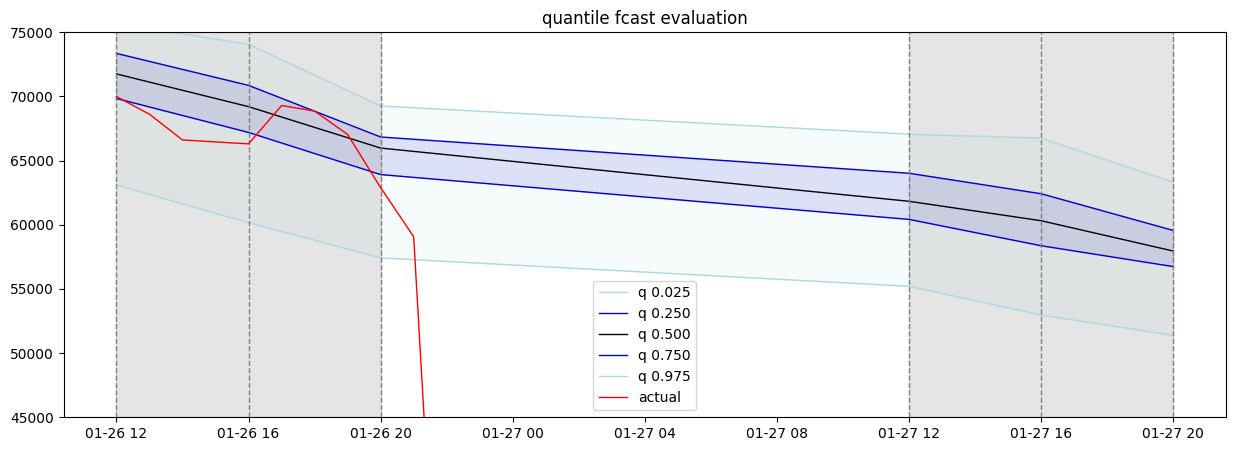

- - - - - - - - - - - - - - - 
entire iterative fcast
- - - - - - - - - - - - - - - 
error computing error metrics
- - - - - - - - - - - - - - - 
submission fcast timestamps
- - - - - - - - - - - - - - - 
error computing MAE q 0.5
error computing error metrics for 2024-01-27 12:00:00+01:00
error computing error metrics for 2024-01-27 16:00:00+01:00
error computing error metrics for 2024-01-27 20:00:00+01:00


,abs error q 0.5,q-score 0.025,q-score 0.250,q-score 0.500,q-score 0.750,q-score 0.975
2024-01-26 12:00:00+01:00,1760.555196,0.344686,0.076695,1.760555,1.679805,0.284283
2024-01-26 16:00:00+01:00,2899.158907,0.307013,1.335867,2.899159,2.278184,0.388246
2024-01-26 20:00:00+01:00,3084.707449,0.273461,1.530331,3.084707,1.974160,0.318338
2024-01-27 12:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-27 16:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-27 20:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN
avg,2581.473851,0.308387,0.980964,2.581474,1.977383,0.330289


In [23]:
# read in csv file
fname_time = t_wednesday.strftime('%Y_%m_%d')
path = f"C:/2023_11-PTSFC/submissions/{fname_time}"

# get csv filename from path that includes Thormund
fnames = [f for f in os.listdir(path) if 'Tormund' in f]
if len(fnames) > 0:
    fname = fnames[0]
else:
    print("no file found")

df_fcast = pd.read_csv(f"{path}/{fname}")
df_fcast = df_fcast[df_fcast.target == 'energy']
df_fcast['timestamp_CET'] = subm_timestamps
# make index = timestamp_CET turned to UTC
df_fcast.index = pd.to_datetime(df_fcast['timestamp_CET']).dt.tz_convert('UTC').rename('timestamp_UTC')
df_fcast = df_fcast[['timestamp_CET', 'q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']]
df_fcast.columns = ['timestamp_CET', 'q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']
df_fcast[['q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']] = df_fcast[['q 0.025', 'q 0.250', 'q 0.500', 'q 0.750', 'q 0.975']] * 1000

# display(df_fcast)
# display(df_energy_new.loc[df_energy_new['timestamp_CET'].isin(df_fcast['timestamp_CET'])])

eval_fcast(df_fcast, df_energy_new, subm_timestamps, quantiles, ylims=[45_000, 75_000])